In [26]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 로드

In [27]:
# txt 파일 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [28]:
# 훈련용 데이터 개수 확인
len(train_data)

150000

In [29]:
# 훈련용 데이터의 형태 파악
# 리뷰의 감성 분석을 하는데 id는 필요하지 않음을 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [30]:
# 테스트 데이터 개수 확인
len(test_data)

50000

In [31]:
# 테스트 데이터 형태 파악
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 데이터 정제하기

In [32]:
# 데이터 중복 값 확인 및 제거
# document: 약 4,000개 중복(총150,000개 - 146,182개), 
# label 2값 확인(0, 1만 가지기 때문에)
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [33]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

In [34]:
print('총 데이터 개수', len(train_data))

총 데이터 개수 146183


<AxesSubplot:>

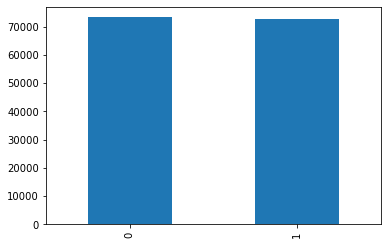

In [35]:
# label 값 bar 그래프로 시각화
train_data['label'].value_counts().plot(kind = 'bar')

In [36]:
# 긍정, 부정 label에 대한 글 개수 확인
print(train_data.groupby('label').size().reset_index(name = 'document_count'))

   label  document_count
0      0           73342
1      1           72841


In [37]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지는 pandas의 isnull().values.any()로 확인
# True일 경우 null 값이 있다는 의미
print(train_data.isnull().values.any())

True


In [38]:
# 어떤 raw에 null값 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [39]:
# null 값을 가진 값이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [40]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [41]:
len(train_data)

146182

In [42]:
# 한글(자음, 모음)과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-42-3843b913aeea>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [43]:
# 댓글 중, 기존에 한글이 없었을 경우 무의미한 데이터이며 
# 해당 데이터를 empty 값으로 변경하여 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


<ipython-input-43-3d42ddd1aede>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


In [44]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [45]:
# null 값들 의미가 없는 데이터이므로 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [46]:
# 테스트 데이터 전처리 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 중복 내용 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-46-7fbda3f9b2e9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식
<ipython-input-46-7fbda3f9b2e9>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


# 토큰화

In [47]:
# 불용어 제거
stopwords = ['1','저','그','ㅋ','을','때','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [48]:
okt = Okt()

In [49]:
X_train = [] # X_train 데이터 변수 생성
for sentence in train_data['document']: # document안 문장을 for문 사용하여 가져옴
    # 텍스트를 단어(형태소)단위로 나누며 단어에서 어간을 추출함
    temp_X = okt.morphs(sentence, stem=True) 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [50]:
# 상위 3개 샘플만 출력
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [51]:
X_test = [] # X_test 데이터 변수 생성
for sentence in test_data['document']: # document안 문장을 for문 사용하여 가져옴
    # 텍스트를 단어(형태소)단위로 나누며 단어에서 어간을 추출함
    temp_X = okt.morphs(sentence, stem=True) 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [52]:
# 상위 3개 샘플만 출력
print(X_test[:3])

[['굳다'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


# 정수 인코딩  
머신이 텍스트를 숫자로 처리하기 위해 정수 인코딩 실행

In [53]:
# 훈련데이터의 단어에 고유한 숫자(정수)가 부여된 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [54]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '이다': 4, '있다': 5, '좋다': 6, '너무': 7, '다': 8, '정말': 9, '되다': 10, '재밌다': 11, '적': 12, '만': 13, '같다': 14, '진짜': 15, '로': 16, '아니다': 17, '않다': 18, '점': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '나': 28, '안': 29, '인': 30, '스토리': 31, '생각': 32, '못': 33, '왜': 34, '드라마': 35, '게': 36, '감동': 37, '사람': 38, '보고': 39, '이렇다': 40, '말': 41, '고': 42, '아깝다': 43, '더': 44, '배우': 45, 'ㅋㅋ': 46, '아': 47, '감독': 48, '거': 49, '그냥': 50, '재미있다': 51, '요': 52, '재미': 53, '시간': 54, '내용': 55, '뭐': 56, '까지': 57, '중': 58, '주다': 59, '자다': 60, '하고': 61, '지루하다': 62, '재미없다': 63, '쓰레기': 64, '수': 65, '네': 66, '모르다': 67, '가다': 68, '들다': 69, '그렇다': 70, '싶다': 71, '지': 72, '작품': 73, '사랑': 74, '알다': 75, '하나': 76, '다시': 77, '마지막': 78, '볼': 79, '이건': 80, '정도': 81, '완전': 82, '오다': 83, 'ㅠㅠ': 84, '많다': 85, '처음': 86, 'ㅋㅋㅋ': 87, '장면': 88, '액션': 89, '주인공': 90, '이렇게': 91, '안되다': 92, '걸': 93, '차다': 94, '나다': 95, '개': 96, '하': 97, '최악': 98, '돈': 99, '이야기': 100, '지금': 101, '넘

In [55]:
# 높은 숫자가 부여된 단어는 빈도수가 낮음을 뜻함
# 등장 빈도수 3회 미만인 단어들 데이터에서 제거
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 rare 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 rare 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 rare 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43747
등장 빈도가 2번 이하인 rare 단어의 수: 24337
단어 집합에서 rare 단어의 비율: 55.63124328525385
전체 등장 빈도에서 rare 단어 등장 빈도 비율: 1.9174183002768266


In [56]:
# 전체 단어 개수 중 빈도수 3번 미만(2회 이하) 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19411


In [57]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [58]:
# 데이터들 정수로 변환된 것을 확인
print(X_train[:3])

[[47, 449, 15, 255, 654], [928, 452, 39, 597, 1, 209, 1444, 23, 956, 670, 18], [381, 2439, 2310, 5666, 2, 217, 8]]


In [59]:
# train_data에서 y_train, y_test 변수 생성
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# empty 샘플 제거
정수 인코딩을 통해 빈도수가 낮은 단어들이 삭제 되었으며 이는    
빈도수 낮은 단어로 구성된 샘플은 이제 빈(empty) 샘플이 되었다는 것을 의미함.  
빈 샘플은 의미가 없으므로 이를 제거해 줌

In [60]:
# 각 샘플 확인하여 길이가 0인 것만 가져옴()
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [61]:
# 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145150
145150


C:\Users\CJ\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


# 패딩  
서로 다른 샘플 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.549982776438167


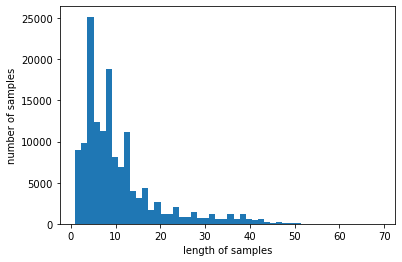

In [62]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [63]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: 
        %s'%(max_len, (cnt / len(nested_list))*100))

In [64]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.69789872545643


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# LSTM으로 네이버 영화 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
pip install -U numpy==1.18.5

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# 리뷰 예측

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))